In [192]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pickle import dump

In [193]:
folders = ['icsa-noniid', 'icsa-iid']
exp_data: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df = df[df['Val F1'] >= 0]
            df['N. Clients'] = df['Client ID'].to_string().split('Client ')[1].split('\n')[0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = folder.split('-')[1] == 'iid'
            df = df[df['FL Round'] > 1]
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) == 3)
            df = df[['IID Data', 'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time',
                     'Val F1']]
            exp_data = pd.concat([exp_data, df])

print(exp_data)

    IID Data  Selector  Total Time of FL Round  Previous F1/Time  \
5      False      True                  109.71          0.001355   
8      False      True                   94.85          0.001764   
11     False      True                   93.49          0.002319   
14     False      True                   98.55          0.002391   
17     False      True                   97.42          0.002553   
..       ...       ...                     ...               ...   
23      True     False                  323.07          0.001421   
27      True     False                  336.99          0.001454   
31      True     False                  315.00          0.001431   
35      True     False                  318.22          0.001548   
39      True     False                  319.48          0.001546   

    Previous Val F1   F1/Time  Val F1  
5            0.1462  0.001764  0.1935  
8            0.1935  0.002319  0.2200  
11           0.2200  0.002391  0.2235  
14           0.2235  0.

In [195]:
x_train = exp_data[['IID Data', 'Selector', 'Previous Val F1']]
y_train = exp_data[['Total Time of FL Round', 'Val F1']]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01)
model_f1 = LinearRegression()
model_f1.fit(x_train, y_train)

with open("../predictors/f1_linear_regressor.pkl", "wb") as f:
    dump(model_f1, f, protocol=5)

tree_f1 = DecisionTreeRegressor(max_depth=4)
tree_f1.fit(x_train, y_train)

with open("../predictors/f1_tree_regressor.pkl", "wb") as f:
    dump(tree_f1, f, protocol=5)
    
x_train = exp_data[['IID Data', 'Selector', 'Previous F1/Time']]
y_train = exp_data[['Total Time of FL Round', 'F1/Time']]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01)
model_f1overtime = LinearRegression()
model_f1overtime.fit(x_train, y_train)

with open("../predictors/f1overtime_linear_regressor.pkl", "wb") as f:
    dump(model_f1overtime, f, protocol=5)

tree_f1overtime = DecisionTreeRegressor(max_depth=4)
tree_f1overtime.fit(x_train, y_train)

with open("../predictors/f1overtime_tree_regressor.pkl", "wb") as f:
    dump(tree_f1overtime, f, protocol=5)

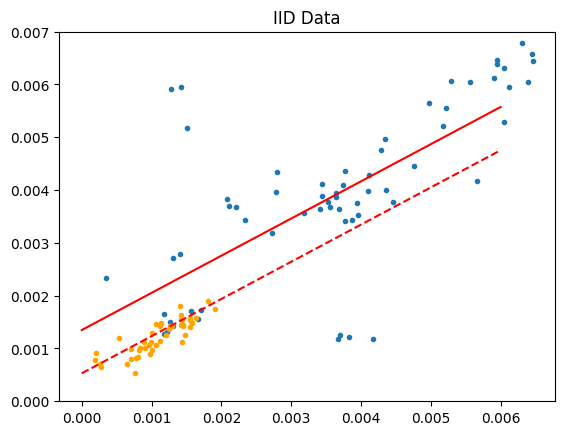

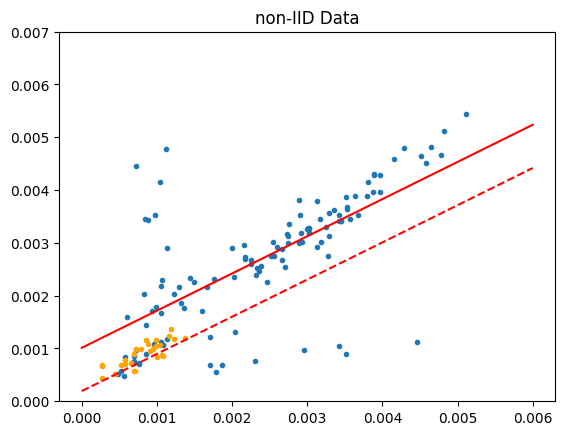

In [196]:
x = np.arange(0, 0.007, 0.001)
plot_data = exp_data[['IID Data', 'Selector', 'Previous F1/Time', 'F1/Time']].values.tolist()

plt.figure()

x_train = [i[2] for i in plot_data if i[0] and i[1]]
y_train = [i[3] for i in plot_data if i[0] and i[1]]
plt.plot(x_train, y_train, '.')
plt.plot(x, [model_f1overtime.predict([[True, True, v]])[0][1] for v in x], color='red')

x_train = [i[2] for i in plot_data if i[0] and not i[1]]
y_train = [i[3] for i in plot_data if i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='orange')
plt.plot(x, [model_f1overtime.predict([[True, False, v]])[0][1] for v in x], '--', color='red')

plt.title('IID Data')
plt.ylim(0, 0.007)

plt.show()

plt.figure()

x_train = [i[2] for i in plot_data if not i[0] and i[1]]
y_train = [i[3] for i in plot_data if not i[0] and i[1]]
plt.plot(x_train, y_train, '.')
plt.plot(x, [model_f1overtime.predict([[False, True, v]])[0][1] for v in x], color='red')

x_train = [i[2] for i in plot_data if not i[0] and not i[1]]
y_train = [i[3] for i in plot_data if not i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='orange')
plt.plot(x, [model_f1overtime.predict([[False, False, v]])[0][1] for v in x], '--', color='red')

plt.title('non-IID Data')
plt.ylim(0, 0.007)

plt.show()

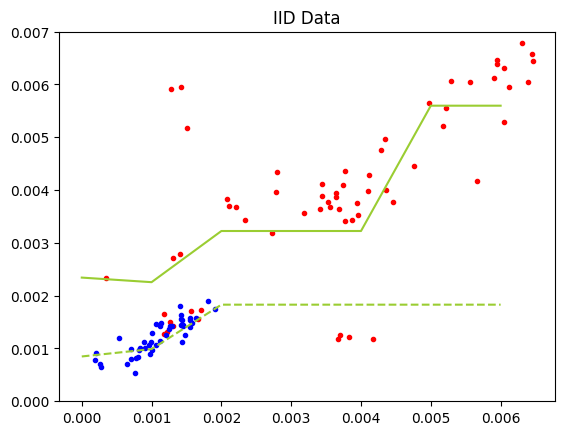

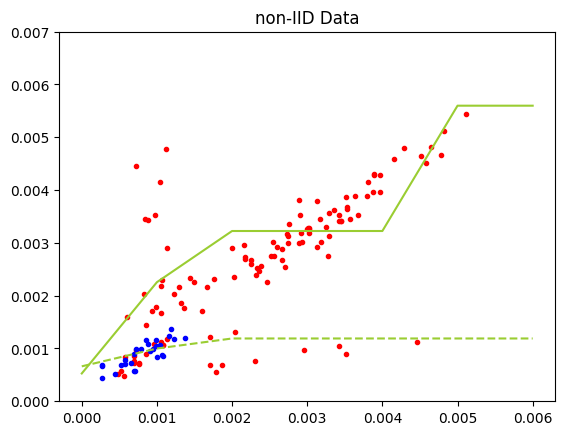

In [197]:
plt.figure()

x_train = [i[2] for i in plot_data if i[0] and i[1]]
y_train = [i[3] for i in plot_data if i[0] and i[1]]
plt.plot(x_train, y_train, '.', color='red')
plt.plot(x, [tree_f1overtime.predict([[True, True, v]])[0][1] for v in x], color="yellowgreen")

x_train = [i[2] for i in plot_data if i[0] and not i[1]]
y_train = [i[3] for i in plot_data if i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x, [tree_f1overtime.predict([[True, False, v]])[0][1] for v in x], '--', color="yellowgreen")

plt.title('IID Data')
plt.ylim(0, 0.007)

plt.show()

plt.figure()

x_train = [i[2] for i in plot_data if not i[0] and i[1]]
y_train = [i[3] for i in plot_data if not i[0] and i[1]]
plt.plot(x_train, y_train, '.', color='red')
plt.plot(x, [tree_f1overtime.predict([[False, True, v]])[0][1] for v in x], color="yellowgreen")

x_train = [i[2] for i in plot_data if not i[0] and not i[1]]
y_train = [i[3] for i in plot_data if not i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='blue')
plt.plot(x, [tree_f1overtime.predict([[False, False, v]])[0][1] for v in x], '--', color="yellowgreen")

plt.title('non-IID Data')
plt.ylim(0, 0.007)

plt.show()